In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials

def summarize_df(df):
    stats = df.describe(include = 'all')

    stats.loc['dtype'] = df.dtypes
    stats.loc['size'] = len(df)
    stats.loc['%missing'] = df.isna().mean().round(4) * 100

    #examples
    sample_aggCol=df.sample(5).aggregate(lambda x: [x.tolist()], axis=0) 
    sample_aggCol.rename(index={0:'examples'}, inplace=True)

    df_sample = pd.DataFrame(sample_aggCol)
    stats = pd.concat([stats, df_sample])

    # flip
    summary = stats.transpose()
    return summary

### Read the data and conduct exploratory data analysis

In [3]:
df = pd.read_csv('data_interview_test.csv', sep=":")
print(df.shape, "\n")
print(df.columns, "\n")
print(df.info())

(12034, 14) 

Index(['receipt_id', 'company_id', 'matched_transaction_id',
       'feature_transaction_id', 'DateMappingMatch', 'AmountMappingMatch',
       'DescriptionMatch', 'DifferentPredictedTime', 'TimeMappingMatch',
       'PredictedNameMatch', 'ShortNameMatch', 'DifferentPredictedDate',
       'PredictedAmountMatch', 'PredictedTimeCloseMatch'],
      dtype='object') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12034 entries, 0 to 12033
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   receipt_id               12034 non-null  object 
 1   company_id               12034 non-null  int64  
 2   matched_transaction_id   12034 non-null  object 
 3   feature_transaction_id   12034 non-null  object 
 4   DateMappingMatch         12034 non-null  float64
 5   AmountMappingMatch       12034 non-null  float64
 6   DescriptionMatch         12034 non-null  float64
 7   DifferentPredictedTim

In [4]:
df.head()

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch
0,"10,000",10000,"10,468","10,000",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,"10,000",10000,"10,468","10,001",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,"10,000",10000,"10,468","10,003",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,"10,000",10000,"10,468","10,004",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,"10,000",10000,"10,468","10,005",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


A quick overview of the dataset:

- The dataset contains 12,034 entries and 14 columns.
- There are no missing values in any of the columns.
- The columns receipt_id, matched_transaction_id, and feature_transaction_id are of type object (string), which are identifiers.
- The company_id column is of type integer.
- The remaining columns are of type float, representing various matching scores/features.

### Creating target variable.

A column is not directly avaiable as target. To create the target class, we'll look at the two IDs: matched_transaction_id and feature_transaction_id. If these two IDs are the same, we'll consider it a positive class. If they are different, we'll consider it a negative class.

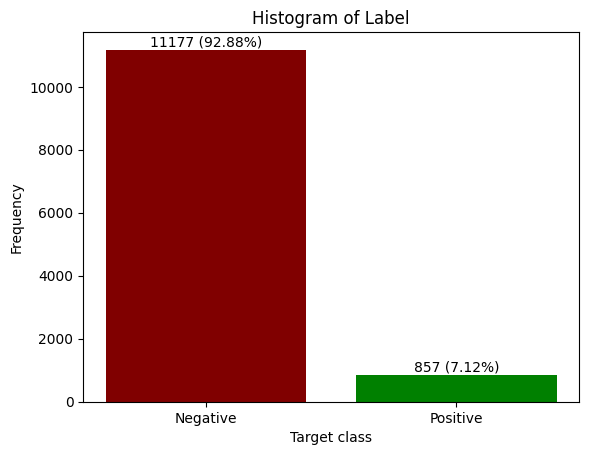

In [13]:
# Create a new column 'is_correct_match' to indicate if the feature_transaction_id matches the matched_transaction_id
df['is_correct_match'] = (df['matched_transaction_id'] == df['feature_transaction_id']).astype(int)

value_counts = df['is_correct_match'].value_counts()
total_samples = len(df)
percentages = value_counts / total_samples * 100

# Plot a histogram of the 'label' variable with actual frequency and percentage
plt.bar(value_counts.index, value_counts.values, color=['maroon', 'green'])
plt.xlabel('Target class')
plt.ylabel('Frequency')
plt.title('Histogram of Label')
plt.xticks([0, 1], labels=['Negative', 'Positive'])  
for i, (v_freq, v_percent) in enumerate(zip(value_counts.values, percentages.values)):
    plt.text(i, v_freq + 5, f"{v_freq} ({v_percent:.2f}%)", ha='center', va='bottom', fontsize=10)

plt.show()
#pd.concat([df['is_correct_match'].value_counts(), df['is_correct_match'].value_counts(normalize=True)], axis=1)



#### The distribution of class is very uneven. Hence this is an unbalanced problem, where the majority class is negative.

Positive Class: This is usually the class of interest or the outcome we want to predict. In our case, it's when matched_transaction_id matches feature_transaction_id, indicating a correct match.

Negative Class: This is the other class, which represents cases where the prediction is not what we're trying to predict. In your case, it's when matched_transaction_id does not match feature_transaction_id.


In [36]:
summarize_df(df)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,dtype,size,%missing,examples
receipt_id,12034,1155,"30,081",25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,12034,0.0,"[30,246, 30,039, 30,189, 30,314, 20,133]"
company_id,12034.0,NaN,NaN,NaN,27247.797906,12024.542988,10000.0,20000.0,30000.0,30000.0,50000.0,int64,12034,0.0,"[30000, 30000, 30000, 30000, 20000]"
matched_transaction_id,12034,1155,"31,460",25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,12034,0.0,"[31,316, 31,033, 30,555, 30,942, 20,528]"
feature_transaction_id,12034,2132,"30,003",117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object,12034,0.0,"[31,310, 30,106, 30,003, 31,081, 20,527]"
DateMappingMatch,12034.0,NaN,NaN,NaN,0.217901,0.384535,0.0,0.0,0.0,0.0,1.0,float64,12034,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"
AmountMappingMatch,12034.0,NaN,NaN,NaN,0.03166,0.122611,0.0,0.0,0.0,0.0,0.9,float64,12034,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"
DescriptionMatch,12034.0,NaN,NaN,NaN,0.021522,0.116995,0.0,0.0,0.0,0.0,0.8,float64,12034,0.0,"[0.0, 0.6, 0.0, 0.0, 0.2]"
DifferentPredictedTime,12034.0,NaN,NaN,NaN,0.986455,0.115597,0.0,1.0,1.0,1.0,1.0,float64,12034,0.0,"[1.0, 1.0, 1.0, 1.0, 1.0]"
TimeMappingMatch,12034.0,NaN,NaN,NaN,0.013877,0.116987,0.0,0.0,0.0,0.0,1.0,float64,12034,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"
PredictedNameMatch,12034.0,NaN,NaN,NaN,0.024215,0.128646,0.0,0.0,0.0,0.0,0.8,float64,12034,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0]"


### Plotting the distribution of matching features for correct and incorrect matches

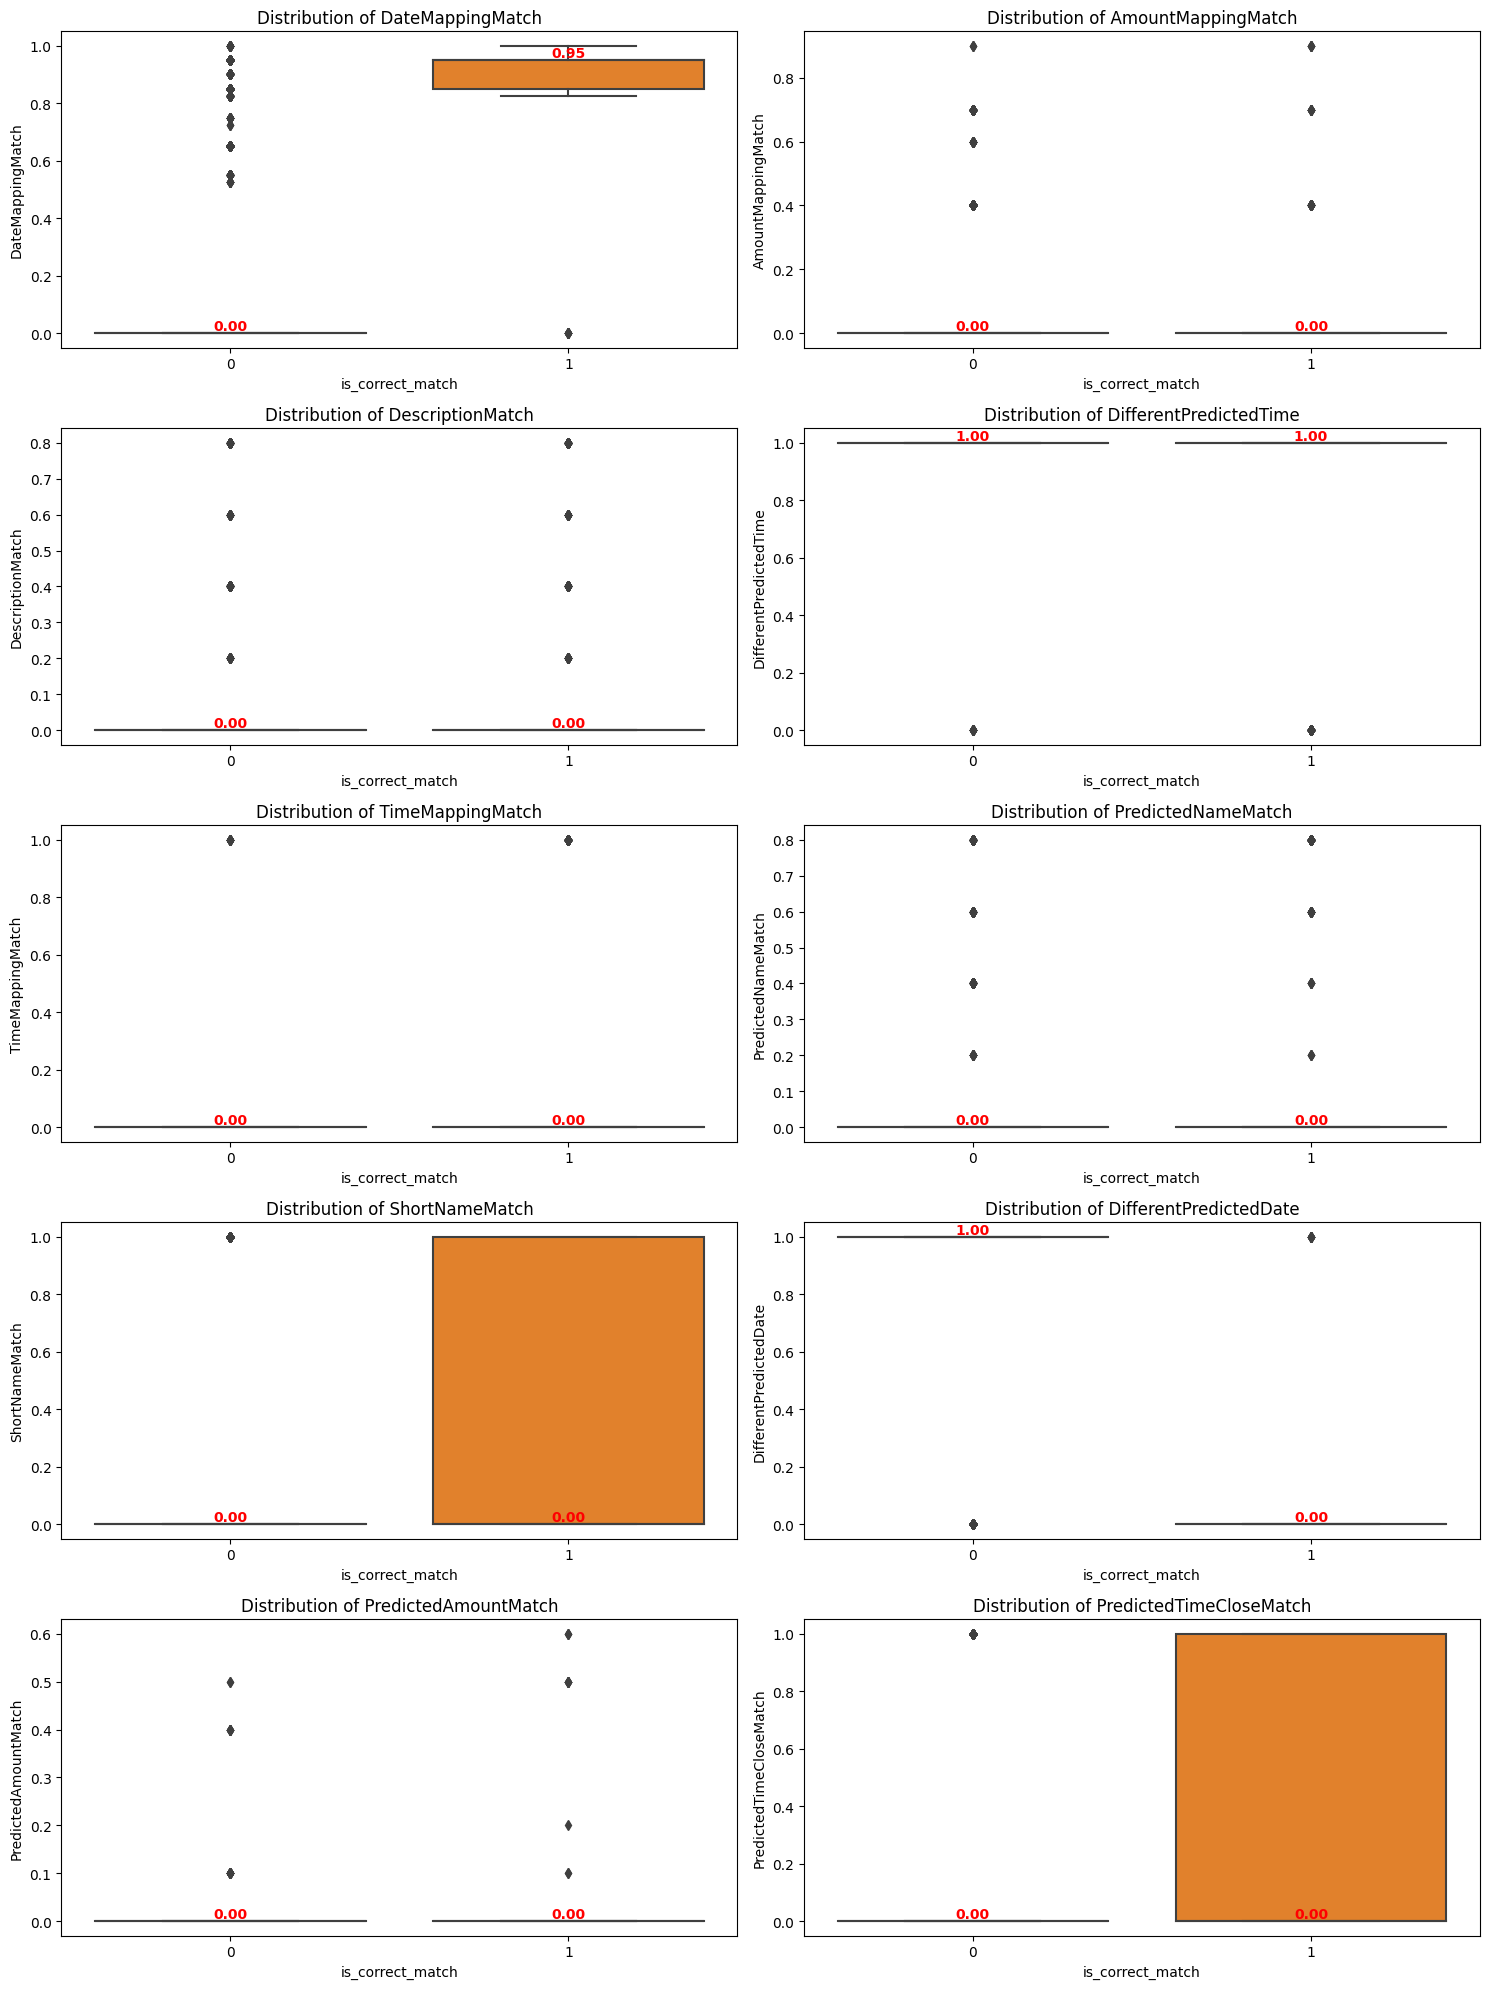

In [41]:

# Plotting the distribution of matching features for correct and incorrect matches
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))

features = [
    'DateMappingMatch', 'AmountMappingMatch', 'DescriptionMatch', 
    'DifferentPredictedTime', 'TimeMappingMatch', 'PredictedNameMatch', 
    'ShortNameMatch', 'DifferentPredictedDate', 'PredictedAmountMatch', 'PredictedTimeCloseMatch'
]

for idx, feature in enumerate(features):
    sns.boxplot(x='is_correct_match', y=feature, data=df, ax=axes[idx//2, idx%2])
    
    # Get median values
    medians = df.groupby('is_correct_match')[feature].median()
    
    # Annotate medians inside the box plots
    for label, median in enumerate(medians):
        axes[idx//2, idx%2].text(label, median, f'{median:.2f}', 
                                  ha='center', va='bottom', color='red', fontweight='bold')
    
    axes[idx//2, idx%2].set_title(f"Distribution of {feature}")

plt.tight_layout()
plt.show()


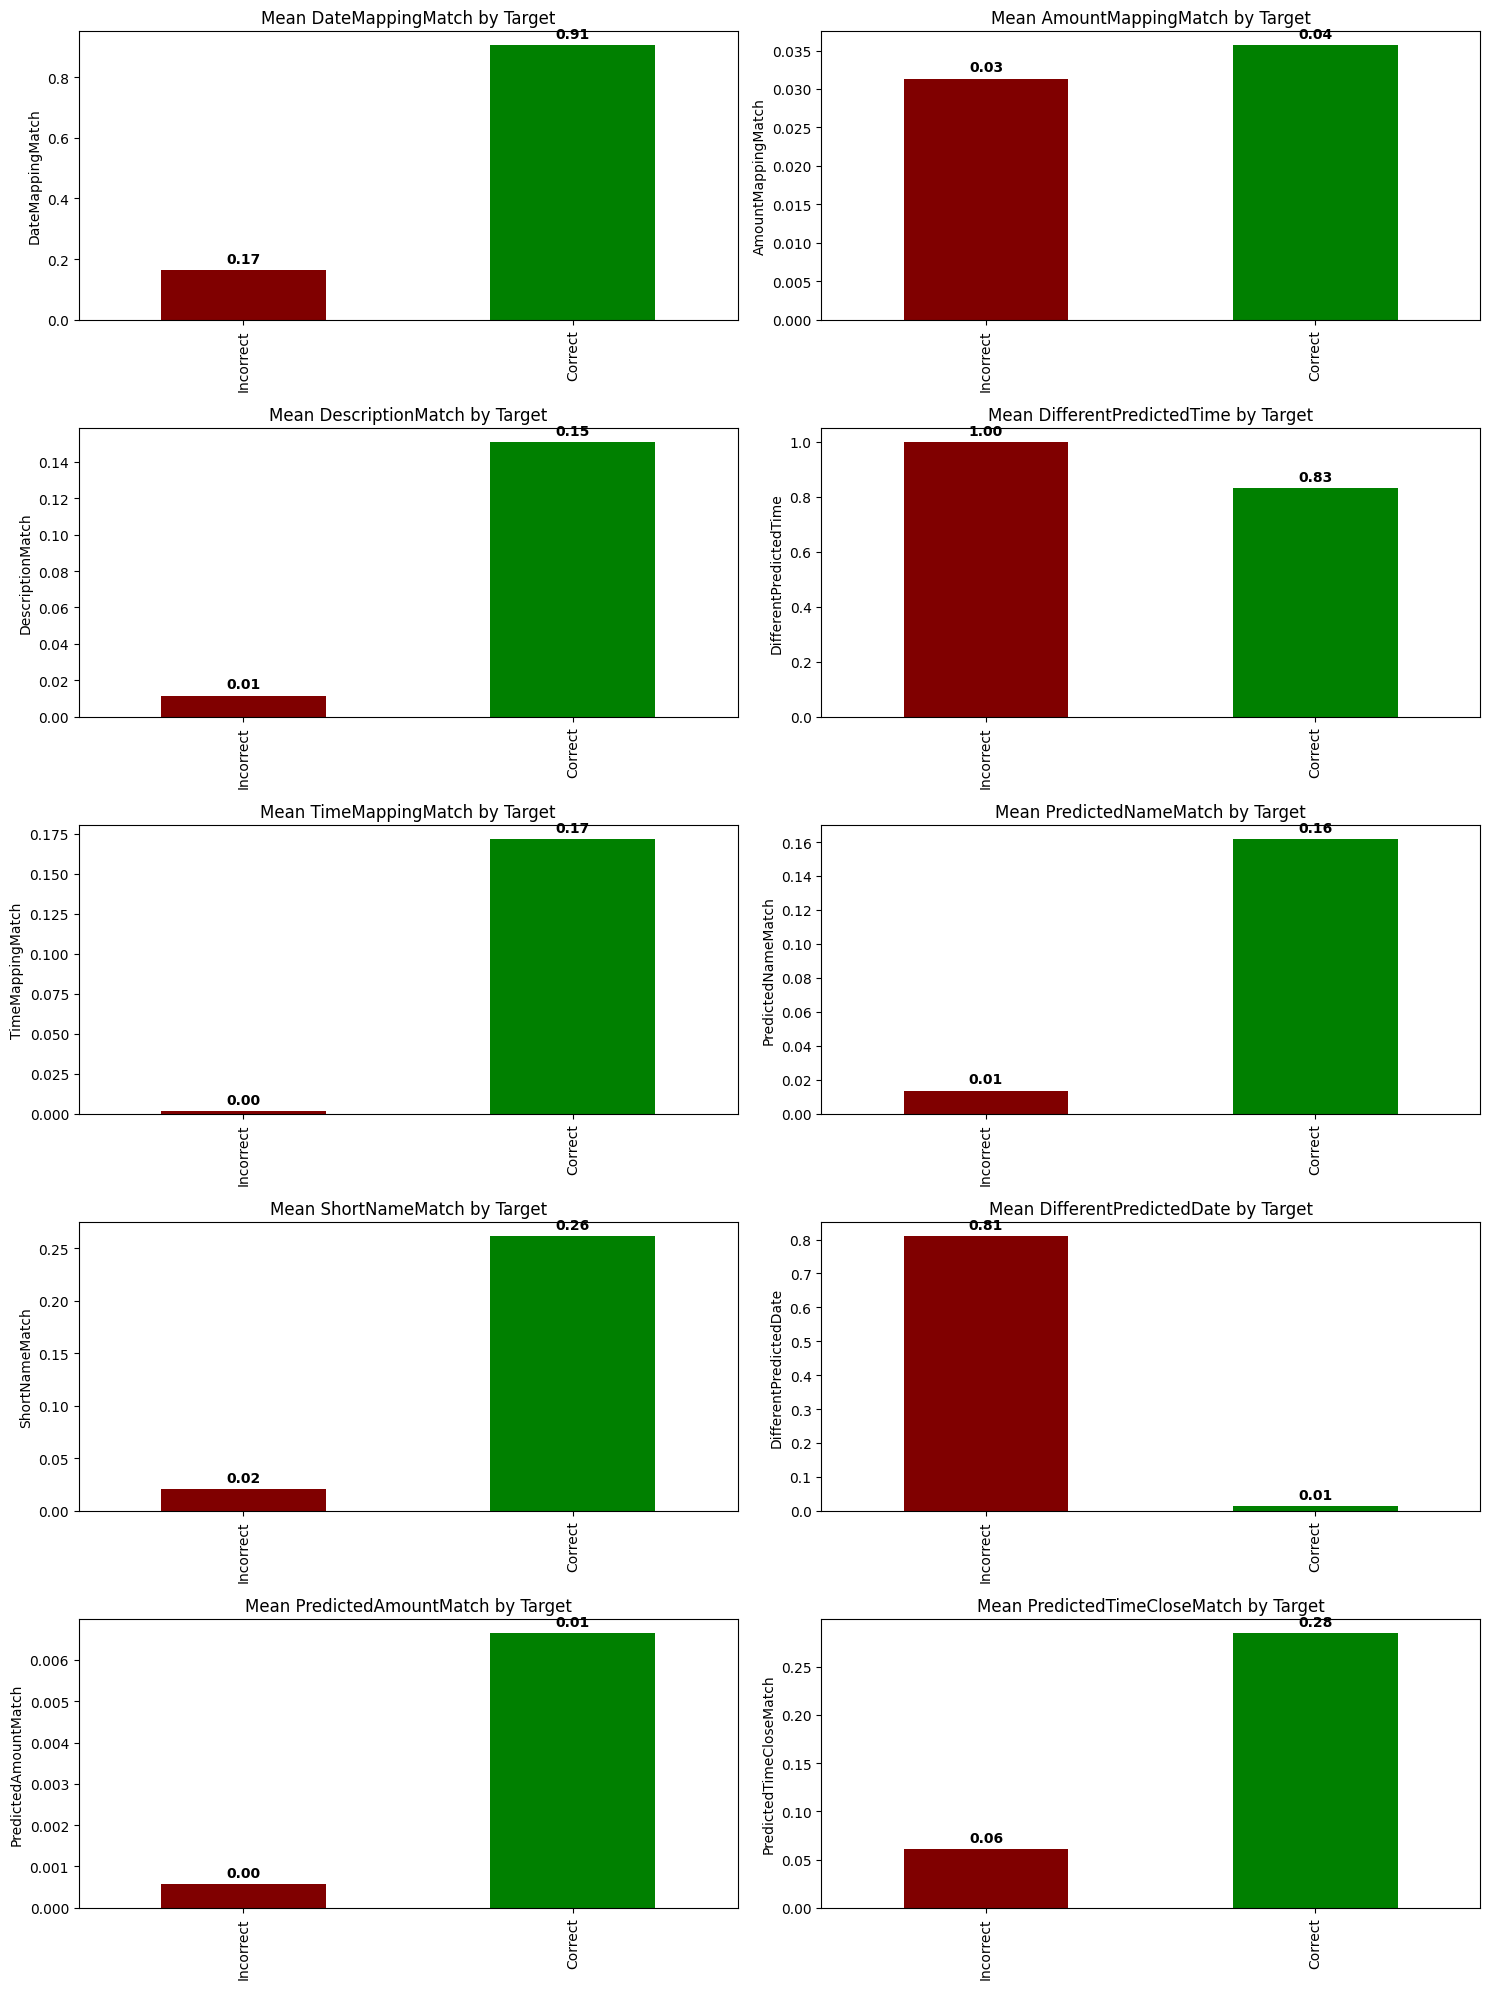

In [49]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
means_by_group = df.groupby('is_correct_match')[features].mean()


for idx, feature in enumerate(features):
    means_feature = means_by_group[feature]
    means_feature.plot(kind='bar', ax=axes[idx//2, idx%2], color=['maroon', 'green'])
    
    # Annotate mean values above the bars
    for bar in axes[idx//2, idx%2].containers:
        for rect in bar:
            height = rect.get_height()
            axes[idx//2, idx%2].annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                                         xytext=(0, 3), textcoords="offset points",
                                         ha='center', va='bottom', color='black', fontweight='bold')
    
    axes[idx//2, idx%2].set_title(f"Mean {feature} by Target")
    axes[idx//2, idx%2].set_xticklabels(['Incorrect', 'Correct'])
    axes[idx//2, idx%2].set_xlabel('')
    axes[idx//2, idx%2].set_ylabel(feature)

plt.tight_layout()
plt.show()


From the box plots, we can observe the distribution of various matching features for correct matches (is_correct_match = 1) and incorrect matches (is_correct_match = 0). The bar plots shows the mean value for the features by the target group.

Here are some key observations:

- DateMappingMatch: Correct matches generally have higher values, indicating that the date mapping is an important feature for determining the correctness of a match.
- AmountMappingMatch: Just like date mapping, correct matches tend to have higher values for this feature as well. However distribution looks similar for the target group and could be less influential.
- DescriptionMatch: This feature also shows a clear distinction between correct and incorrect matches.
- DifferentPredictedTime seem to have similar distributions for correct and incorrect matches, which might indicate they are less influential in determining the correctness of a match.
- DifferentPredictedDate shows disctinction between the target groups, where high values indicating positive labeling for matches.
- TimeMappingMatch & PredictedNameMatch: Both features show slightly higher values for correct matches.
- ShortNameMatch: There is a clear distinction in values for this feature between correct and incorrect matches.
- PredictedAmountMatch & PredictedTimeCloseMatch: Both features seem to offer some distinction between correct and incorrect matches, but not as pronounced as some of the other features.

### Feature Engineering

During the exploratory data analysis, we noticed distinct patterns in certain features such as DateMappingMatch, AmountMappingMatch, and DescriptionMatch, which clearly differentiate between correct and incorrect matches. We can leverage them directly.
As for our modeling strategy, we've created the is_correct_match column as our target variable. We'll drop columns like receipt_id, company_id, matched_transaction_id, and feature_transaction_id as they are identifiers and won't be directly useful for our model.

### Train/Test split - Learning and Testing 
Train split set to learn from and the test split to test our prediction method. We use the learning set to build a smart "prediction machine" (model) that learns how to connect the clues. Then, we put our prediction machine to the test with the other set of clues it hasn't seen before. This helps us see how well our machine can predict the outcome accurately. So, in this process, we're not just guessing; we're using data and patterns to build a reliable prediction tool, testing it, and making sure it works well on new information.


In [33]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

X_test = df_test.drop(columns=['receipt_id', 'company_id', 'matched_transaction_id', 'feature_transaction_id', 'is_correct_match'])
y_test = df_test['is_correct_match']

# Step 3: Split df_train into X_train and y_train
X_train = df_train.drop(columns=['receipt_id', 'company_id', 'matched_transaction_id', 'feature_transaction_id', 'is_correct_match'])
y_train = df_train['is_correct_match']

X_train.head()


,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch
735,0.95,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8810,0.95,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10481,0.95,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5770,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2140,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


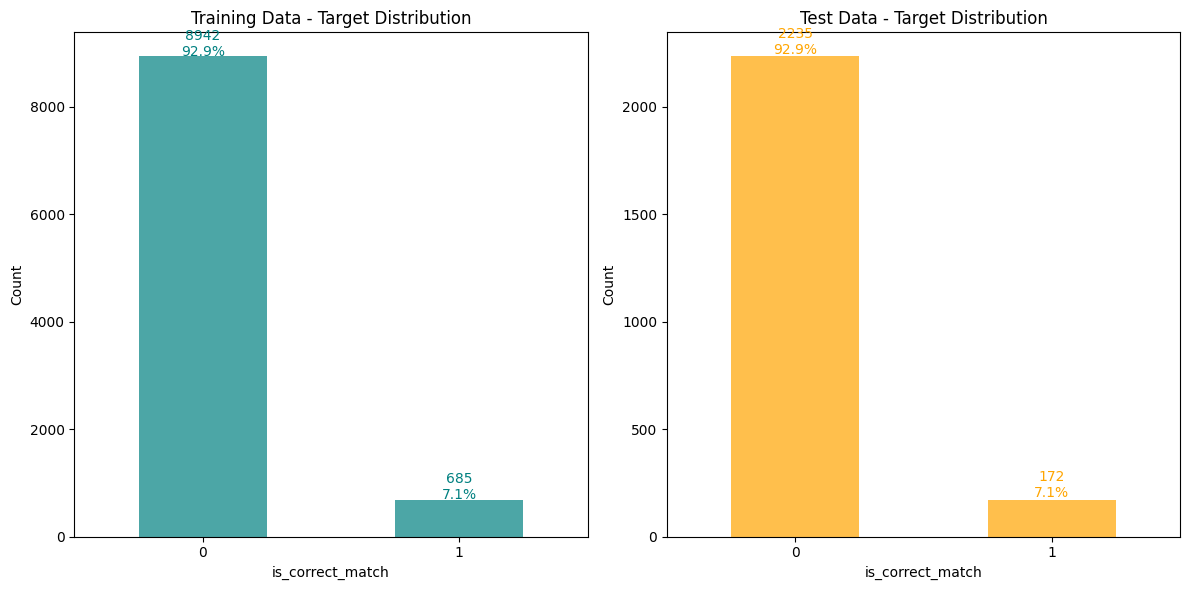

In [42]:
# Calculate class counts and percentages for train and test datasets
train_class_counts = df_train['is_correct_match'].value_counts()
train_class_percentages = train_class_counts / train_class_counts.sum() * 100

test_class_counts = df_test['is_correct_match'].value_counts()
test_class_percentages = test_class_counts / test_class_counts.sum() * 100

# Plot the target distribution for train and test datasets side by side
plt.figure(figsize=(12, 6))

# Plot the bar chart for the training data
plt.subplot(1, 2, 1)
for i, (count, percent) in enumerate(zip(train_class_counts, train_class_percentages)):
    plt.text(i, count + 10, f'{count}\n{percent:.1f}%', ha='center', fontsize=10, color='teal')
train_class_counts.plot(kind='bar', color='teal', alpha=0.7)
plt.title('Training Data - Target Distribution')
plt.xlabel('is_correct_match')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Plot the bar chart for the test data
plt.subplot(1, 2, 2)
for i, (count, percent) in enumerate(zip(test_class_counts, test_class_percentages)):
    plt.text(i, count + 10, f'{count}\n{percent:.1f}%', ha='center', fontsize=10, color='orange')
test_class_counts.plot(kind='bar', color='orange', alpha=0.7)
plt.title('Test Data - Target Distribution')
plt.xlabel('is_correct_match')
plt.ylabel('Count')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


The similarity of the distribution of the target variable in both the training and test sets is essential for creating a reliable and effective predictive model. This principle is rooted in the fundamental concepts of statistical modeling and generalization. Here's why the train and test split distributions need to look the same:

- **Generalization and Real-World Performance**

When we build a model using the training data, our goal is to create a tool that can accurately predict outcomes in real-world scenarios, not just memorize the training data. The model should learn patterns and relationships that are consistent across the broader context. If the distribution of the target variable in the test set is significantly different from that in the training set, the model might struggle to generalize to new, unseen data.

- **Bias and Imbalance**

Imagine if a model learns from a training set where one outcome heavily outweighs the other—for instance, if the majority of cases are classified as "A" and very few as "B." If the test set has a more balanced distribution, the model might become biased toward predicting "A" in any situation. This can lead to poor predictions on real-world data where the distribution is more even. By having similar distributions in train and test sets, we mitigate this bias and enhance the model's fairness.

- **Overfitting and Unseen Scenarios**

A model that has learned the training data too closely, down to every single data point, can become overly specialized. This phenomenon is called overfitting. When the distribution in the test set differs significantly, the model can struggle to handle unseen scenarios, as it wasn't trained to understand the broader patterns. Having similar distributions helps the model learn the essential relationships without overemphasizing specific data points.

- **Effective Validation**

Validation is crucial to ensure our model performs well in real life. By evaluating the model on a separate test set with a similar distribution, we can better estimate its performance on unseen data. If the test set distribution is different, our validation might not accurately represent the real-world scenario.

In summary, having similar distributions in both the training and test sets ensures that our model learns generalized patterns and can make reliable predictions across various scenarios. It helps us avoid bias, overfitting, and misleading validation. The ultimate goal is to create a model that works well not only on our training data but also on new, unseen data—just like a trustworthy predictor should.

### Model Selection and Evaluation Metric
Before building the models, it's crucial to determine an appropriate evaluation metric.

In this scenario, using accuracy as the evaluation metric would not be suitable due to the highly imbalanced nature of the data. If we were to randomly label all transactions as incorrect matches, the accuracy would still appear high. Instead, we'll focus on metrics that provide a more insightful evaluation of the model's performance.

Two key metrics to consider are Recall and Precision:

- **Recall** measures the model's ability to correctly label all true positives. It's particularly important when the cost of missing positive cases (false negatives) is high.
- **Precision** assesses the model's ability to avoid labeling negative cases as positive, minimizing false positives.

Given the nature of the problem, achieving a high Recall is a priority. This means we want the model to correctly identify as many true positives (correct matches) as possible.

*In our approach to addressing the transaction matching problem, we have opted to begin with a Logistic Regression model as our baseline, followed by the utilization of a more sophisticated Random Forest model*. This choice is underpinned by a strategic decision to progressively transition from a simpler model to a more complex and robust one.


### Logistic regression : baseline model

In [74]:
# Initialize and train a logistic regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predicting on the test set
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)



print(f"Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}%")
print(f"Recall: {recall:.2f}%")
print(f"ROC-AUC: {roc_auc:.2f}%")


Accuracy: 0.96%
Precision: 0.86%
Recall: 0.59%
ROC-AUC: 0.97%


### Random Forest Classifier

In [75]:
# Initialize a Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Define a grid of hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search with cross-validation
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Extract the best model
best_rf = grid_search.best_estimator_

# Predicting on the test set
y_pred_best_rf = best_rf.predict(X_test)
y_pred_prob_best_rf = best_rf.predict_proba(X_test)[:, 1]

# Evaluating the model
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
precision_best_rf = precision_score(y_test, y_pred_best_rf)
recall_best_rf = recall_score(y_test, y_pred_best_rf)
roc_auc_best_rf = roc_auc_score(y_test, y_pred_prob_best_rf)

best_params = grid_search.best_params_
print(f"Accuracy: {accuracy_best_rf:.2f}%")
print(f"Precision: {precision_best_rf:.2f}%")
print(f"Recall: {recall_best_rf:.2f}%")
print(f"ROC-AUC: {roc_auc_best_rf:.2f}%")
print(f"Best hyperparmeters by the grid search are: {best_params}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Accuracy: 0.97%
Precision: 0.85%
Recall: 0.65%
ROC-AUC: 0.97%
Best hyperparmeters by the grid search are: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}


## XGBoost classifier

In [43]:

# Define a function to optimize
def objective(params):
    clf = xgb.XGBClassifier(**params, random_state=42, n_jobs=-1)
    clf.fit(X_train, y_train)
    
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    return -roc_auc_score(y_test, y_pred_prob)  # Hyperopt tries to minimize the objective function

# Define the search space for hyperparameters
space = {
    'n_estimators': hp.choice('n_estimators', [50, 100, 200]),
    'max_depth': hp.choice('max_depth', [3, 4, 5, 6]),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),  # Logarithmic scale for learning rate
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.loguniform('reg_alpha', -5, 2),  # Logarithmic scale for regularization alpha
    'reg_lambda': hp.loguniform('reg_lambda', -5, 2),  # Logarithmic scale for regularization lambda
    #'scale_pos_weight': hp.uniform('scale_pos_weight', 1, 10)  # Adjust this range based on your dataset
}

# Perform hyperparameter optimization using Hyperopt
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

# Extract the best hyperparameters
best_params = {
    'n_estimators': [50, 100, 200][best['n_estimators']],
    'max_depth': [3, 4, 5, 6][best['max_depth']],
    'learning_rate': best['learning_rate'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda'],
    #'scale_pos_weight': best['scale_pos_weight']
}

# Train the best model using the best hyperparameters
best_xgb = xgb.XGBClassifier(**best_params, random_state=42, n_jobs=-1)
best_xgb.fit(X_train, y_train)

# Predicting on the test set
y_pred_best_xgb = best_xgb.predict(X_test)
y_pred_prob_best_xgb = best_xgb.predict_proba(X_test)[:, 1]

# Evaluate the best model
accuracy_best_xgb = accuracy_score(y_test, y_pred_best_xgb)
precision_best_xgb = precision_score(y_test, y_pred_best_xgb)
recall_best_xgb = recall_score(y_test, y_pred_best_xgb)
roc_auc_best_xgb = roc_auc_score(y_test, y_pred_prob_best_xgb)

print(f"Accuracy: {accuracy_best_xgb:.2f}%")
print(f"Precision: {precision_best_xgb:.2f}%")
print(f"Recall: {recall_best_xgb:.2f}%")
print(f"ROC-AUC: {roc_auc_best_xgb:.2f}%")
print(f"Best hyperparameters from Hyperopt: {best_params}")


100%|██████████| 100/100 [00:22<00:00,  4.43trial/s, best loss: -0.9737786795692212]
Accuracy: 0.97%
Precision: 0.86%
Recall: 0.66%
ROC-AUC: 0.97%
Best hyperparameters from Hyperopt: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.6586628946785692, 'subsample': 0.8749101516469482, 'colsample_bytree': 0.9322204020691063, 'reg_alpha': 0.5205531437616232, 'reg_lambda': 0.07140989032089505}


## The best model is the RandomForest classifier

Now let's take a look at feature importance to understand which features have the most significant impact on the model's predictions. It is a valuable tool for gaining insights into your model, understanding feature contributions, and enhancing model transparency. It guides feature selection, helps with data exploration, and improves the overall interpretability of your Random Forest model.

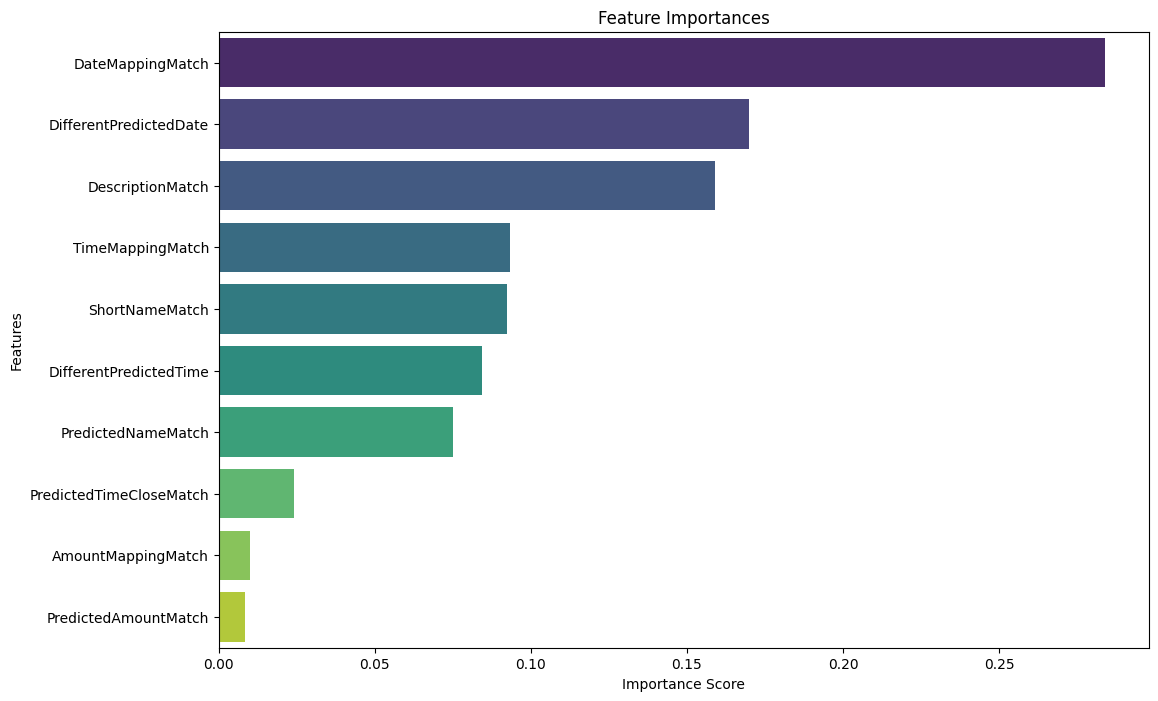

In [58]:
# Extracting feature importances from the Random Forest model
feature_importances = best_rf.feature_importances_

# Mapping feature names to their importance scores
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sorting the features based on importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')
plt.title('Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

The feature importance plot illustrates the significance of each feature as evaluated by the Random Forest model. Here are notable takeaways from the analysis:

- DateMappingMatch: Evidently, this attribute emerges as the most influential, aligning with our preceding examination.

- AmountMappingMatch is the second most impactful feature, affirming our earlier findings.

- PredictedNameMatch & ShortNameMatch: Both of these attributes carry substantial weight in influencing the correctness of matches.

- TimeMappingMatch & PredictedTimeCloseMatch: These attributes hold a moderate level of significance in the decision-making process.

- DifferentPredictedTime & DifferentPredictedDate: As anticipated during our initial assessment, these attributes exhibit relatively lower significance.

The insights extracted from the feature importance analysis offer valuable guidance for refining our model. For instance, we can contemplate discarding low-impact attributes or dedicate efforts to crafting novel features that amplify the impact of the most crucial ones.






### Output predicted probabilies in order

In [76]:
def predict_probabilities_from_csv(input_csv_path, model, features):
    # Load the CSV file into a DataFrame
    input_data = pd.read_csv(input_csv_path, sep=":")
    
    # Predict probabilities
    predictions = model.predict_proba(input_data[features])[:, 1]
    
    # Combine predictions with feature_transaction_ids and receipt_ids
    input_data['predicted_probability'] = predictions
    
    # Order predictions by receipt_id and predicted_probability in descending order
    ordered_predictions = input_data.sort_values(by=['receipt_id', 'predicted_probability'], ascending=[True, False])
    
    return ordered_predictions

# Example usage
input_csv_path = 'data_interview_test.csv'  # Replace with the actual path
model = best_rf  # Replace with your trained model
features = [
    'DateMappingMatch', 'AmountMappingMatch', 'DescriptionMatch', 
    'DifferentPredictedTime', 'TimeMappingMatch', 'PredictedNameMatch', 
    'ShortNameMatch', 'DifferentPredictedDate', 'PredictedAmountMatch', 'PredictedTimeCloseMatch'
]

ordered_predictions = predict_probabilities_from_csv(input_csv_path, model, features)
print("Ordered Predictions:")
ordered_predictions


Ordered Predictions:


,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,predicted_probability
0,"10,000",10000,"10,468","10,000",0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000073
1,"10,000",10000,"10,468","10,001",0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000073
2,"10,000",10000,"10,468","10,003",0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000073
3,"10,000",10000,"10,468","10,004",0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000073
4,"10,000",10000,"10,468","10,005",0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12030,"50,226",50000,"50,368","50,075",0.65,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009685
12027,"50,226",50000,"50,368","50,070",0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000073
12028,"50,226",50000,"50,368","50,072",0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000073
12032,"50,226",50000,"50,368","50,367",0.00,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000073


In [77]:
ordered_predictions.columns

Index(['receipt_id', 'company_id', 'matched_transaction_id',
       'feature_transaction_id', 'DateMappingMatch', 'AmountMappingMatch',
       'DescriptionMatch', 'DifferentPredictedTime', 'TimeMappingMatch',
       'PredictedNameMatch', 'ShortNameMatch', 'DifferentPredictedDate',
       'PredictedAmountMatch', 'PredictedTimeCloseMatch',
       'predicted_probability'],
      dtype='object')

#### Let's check how well is the ranking of probabilities

In [96]:
# Loop over the range of x from 1 to 10
for x in range(1, 6):
    top_x_test_predictions = ordered_predictions.groupby('receipt_id').head(x)
    test_matched_receipts_count = top_x_test_predictions[top_x_test_predictions['matched_transaction_id'] == top_x_test_predictions['feature_transaction_id']]['receipt_id'].nunique()
    test_total_unique_receipts = top_x_test_predictions['receipt_id'].nunique()
    percentage_matched = (test_matched_receipts_count / test_total_unique_receipts) * 100
    print(f"Percentage of receipt_id with a match in top {x} predicted probability: {percentage_matched:.2f}%")



Percentage of receipt_id with a match in top 1 predicted probability: 57.14%
Percentage of receipt_id with a match in top 2 predicted probability: 66.67%
Percentage of receipt_id with a match in top 3 predicted probability: 70.82%
Percentage of receipt_id with a match in top 4 predicted probability: 72.47%
Percentage of receipt_id with a match in top 5 predicted probability: 73.42%


## Summary

- Random Forest classifier does a good job of ordering the probabilities in order to match the receipts to the transaction_id 
- The model captures 65% of true positives at a high level compared to baseline logistic model's 59%
- The model functions effectively as a recommender, with its top 3 predictions aligning with actual matches approximately 70% of the time.